## Importing Libraries

In [81]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [235]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.image import resize
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers.legacy import Adam

## Melspectrogram Visualization

In [84]:
#A regular spectrogram displays the intensity of frequencies on a linear scale, meaning that it provides equal emphasis on both low and high frequencies.
#The Mel spectrogram applies a Mel filter bank to the original spectrogram, effectively compressing the frequency axis in a way that better reflects human auditory perception.
#This means fewer frequency bands are needed to represent the same perceptual information.

In [85]:
#Plotting Melspectrogram of Entire Audio
def plot_melespectrogram(y,sr):
    #Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)#mimic the way humans perceive sound
    #Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)#works like a human ear,easy for vissualization
    #Visualize the spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')#heatmap
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()


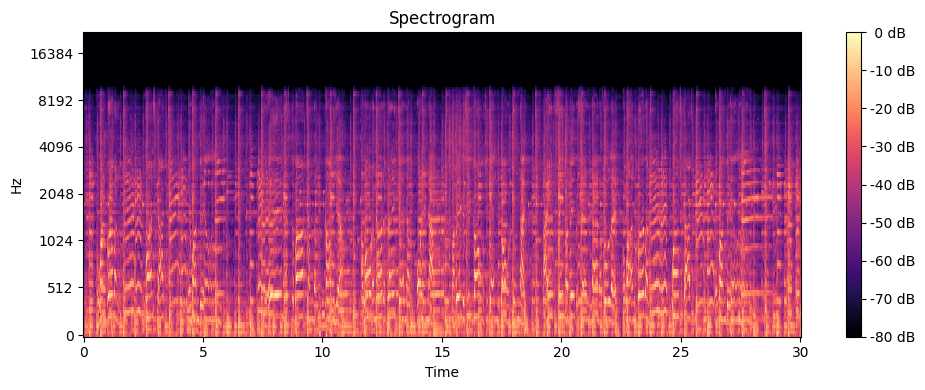

In [89]:
random_file_name = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00000.wav" # Correct absolute path to the audio file
y,sr = librosa.load(random_file_name,sr=44100)
target_shape=(150,150)
plot_melespectrogram(y,sr)

In [139]:
def plot_melspectrogram_chunks(y,sr):
    #define the duration of each chunk and overlap
    chunk_duration = 4 #seconds
    overlap_duration = 2 #seconds

    #Convert duration to sample
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    #Calculate the number of chunks
    num_chunks = int(np.ceil((len(y)-chunk_samples)/(chunk_samples-overlap_samples)))

    #iterate over each chunks
    for i in range(num_chunks):
        #Calculate start and end indices of the chunk
        start = i*(chunk_samples-overlap_samples)
        end = start+chunk_samples
        #Extract the chunk audio
        chunk = y[start:end]
        #Melspectrogram part
        spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        print(spectrogram.shape)
        spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
        #Visualize the spectrogram
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()#adjusts the spacing between the plots so they don’t overlap and are easier to read.
        plt.show()

(128, 345)


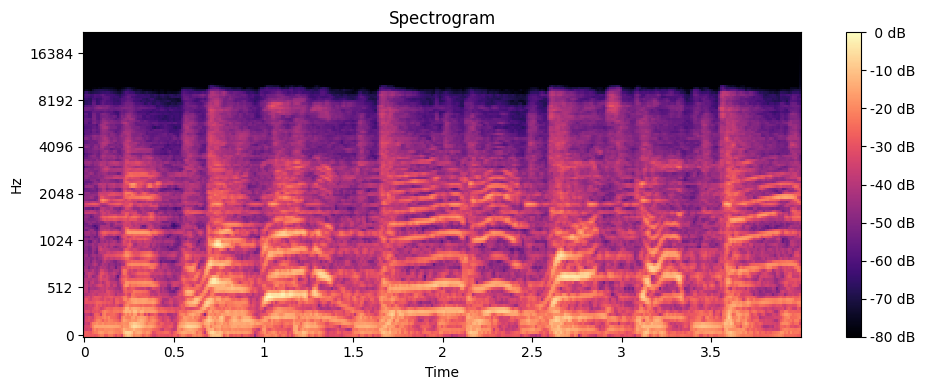

(128, 345)


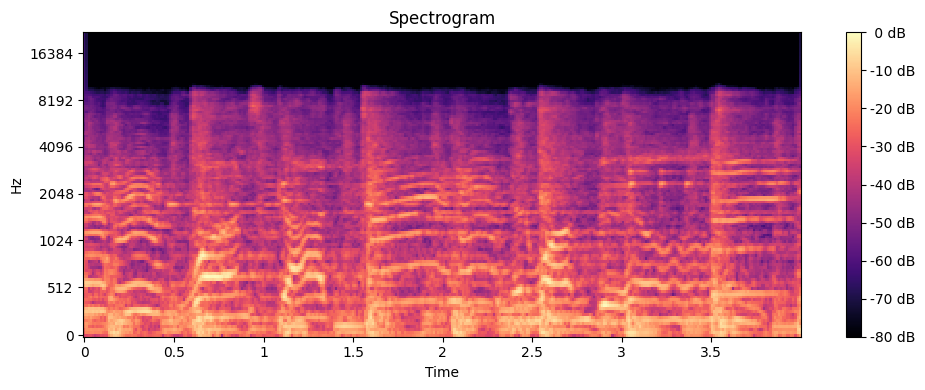

(128, 345)


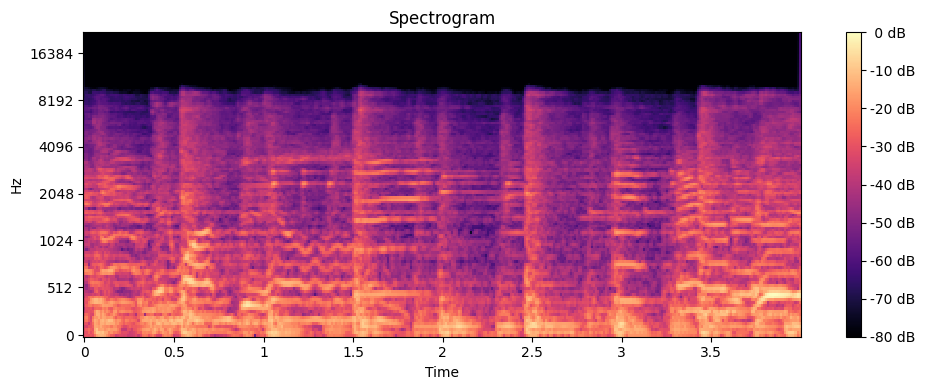

(128, 345)


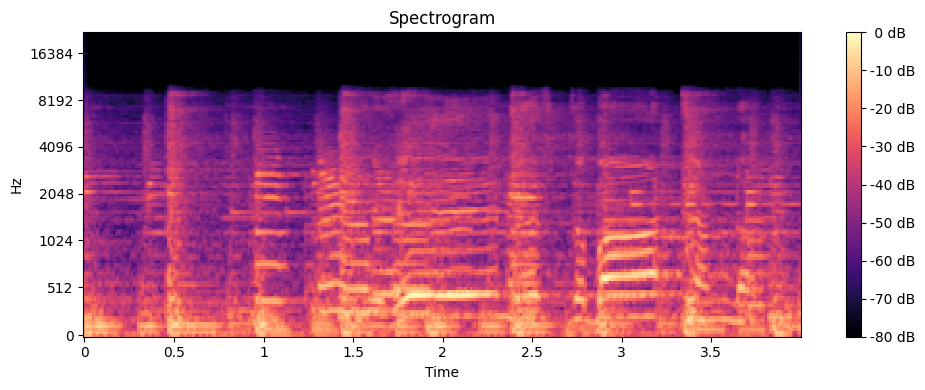

(128, 345)


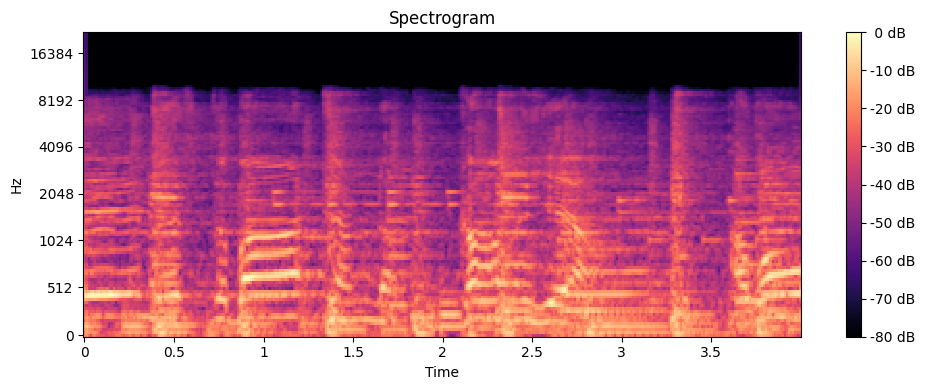

(128, 345)


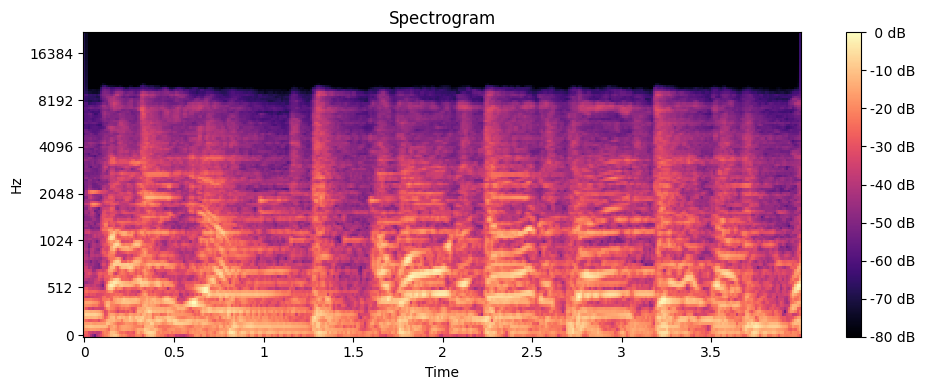

(128, 345)


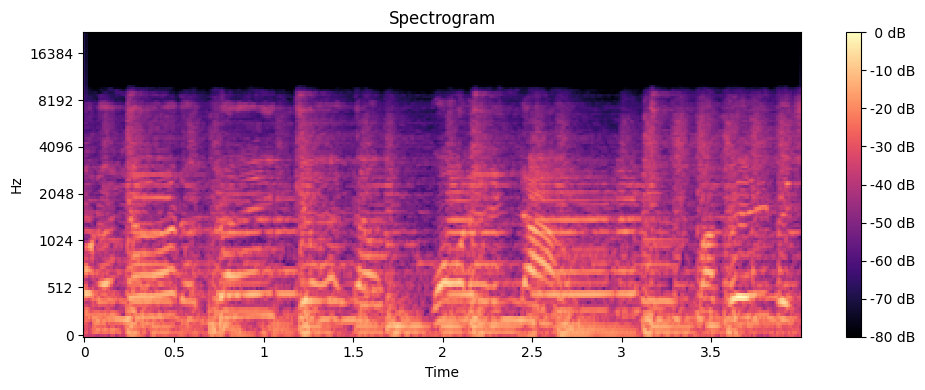

(128, 345)


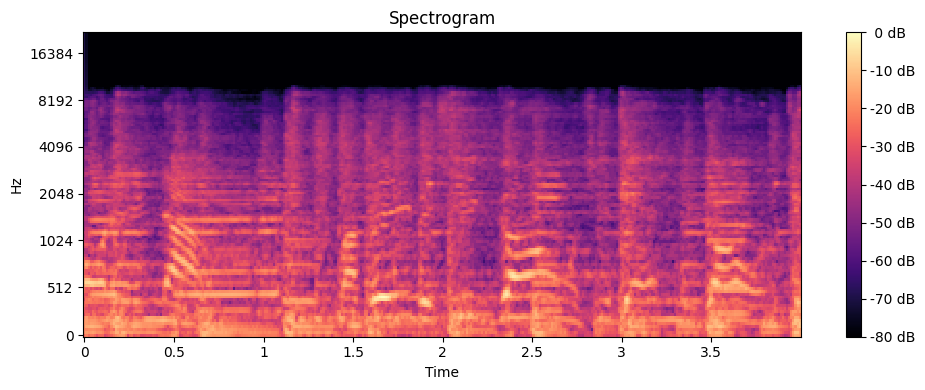

(128, 345)


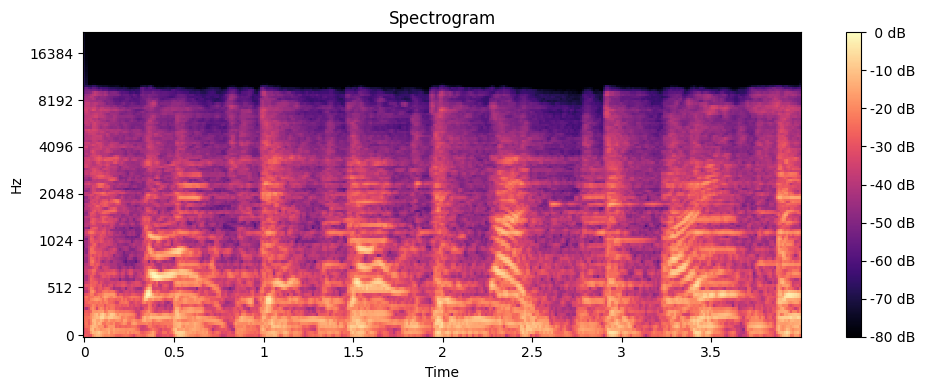

(128, 345)


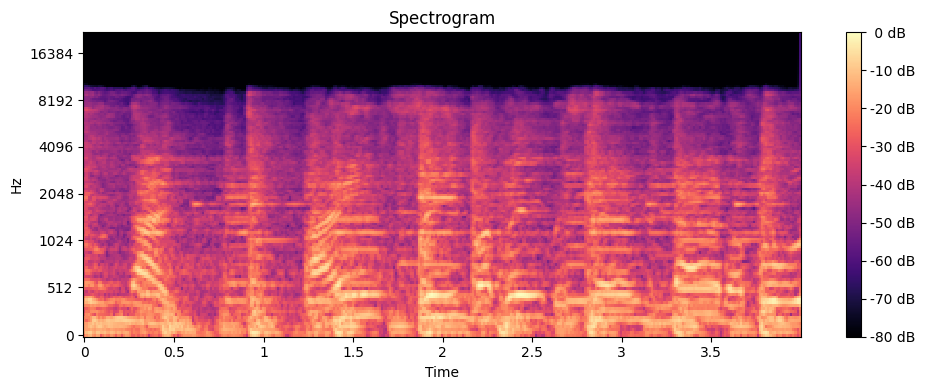

(128, 345)


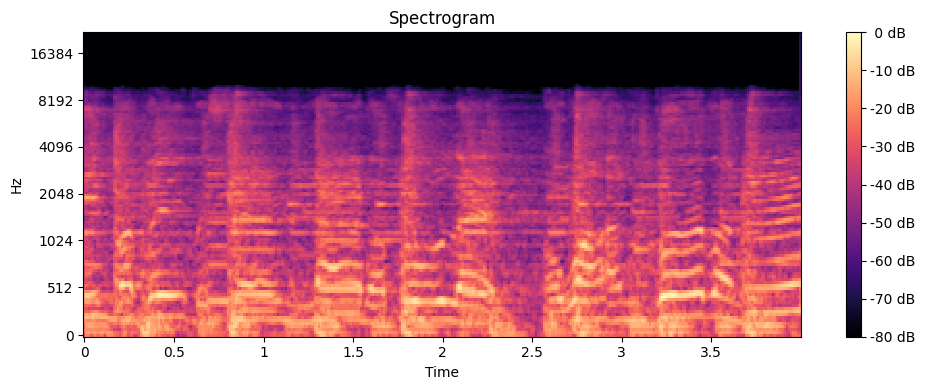

(128, 345)


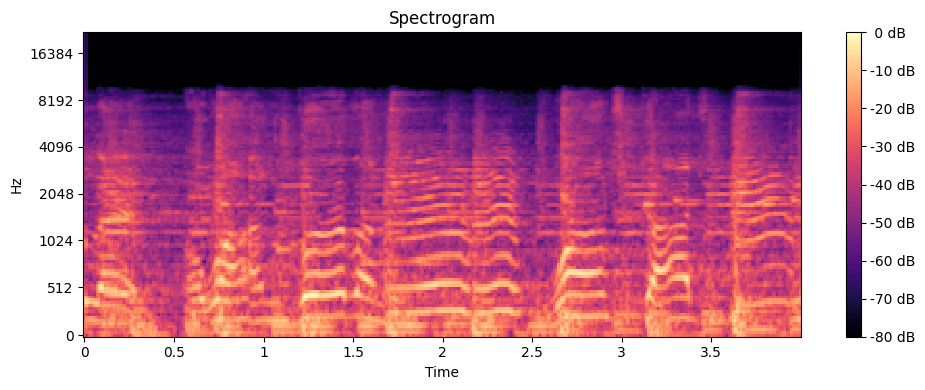

(128, 345)


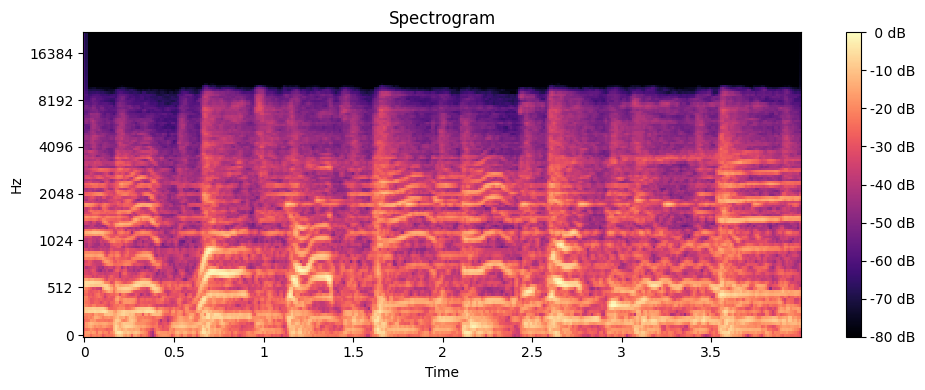

(128, 345)


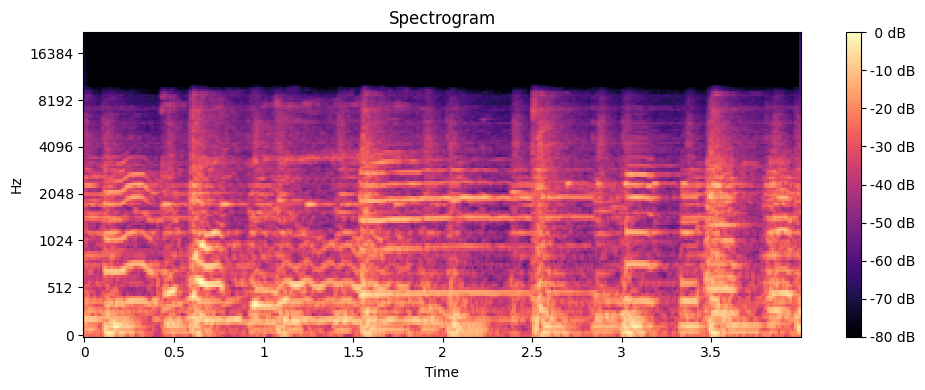

In [140]:
plot_melspectrogram_chunks(y,sr)

## Data Preprocessing - Final

In [141]:
#define your folder structure
data_dir = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/"
classes = ['classical','jazz','pop','rock']

In [142]:

#Load and preprocess audio data
def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                # Try to load the audio file using librosa.load
                try:
                    audio_data,sample_rate = librosa.load(file_path,sr=None,mono=True)
                # If librosa.load fails due to an unsupported format, skip the file and print a warning
                except:
                    print(f"Warning: Skipping file {filename} due to unsupported format:")
                    continue  # Skip to the next file
                #Performing Preprocessing
                #define the duration of each chunk and overlap
                chunk_duration = 4
                overlap_duration = 2

                #Convert duration to sample
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                #Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))

                #iterate over each chunks
                for i in range(num_chunks):
                    #Calculate start and end indices of the chunk
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    #Extract the chunk audio
                    chunk = audio_data[start:end]
                    #Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    #Resize matrix based on provided target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #Return
    return np.array(data),np.array(labels)

In [143]:
data,labels = load_and_preprocess_data(data_dir,classes)

Processing-- classical
Processing-- jazz


<ipython-input-142-304d32753c07>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data,sample_rate = librosa.load(file_path,sr=None,mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Processing-- pop
Processing-- rock


In [144]:
data.shape

(5582, 150, 150, 1)

In [145]:
labels.shape

(5582,)

In [146]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [147]:
labels.shape

(5582, 4)

## Splitting of Dataset into Training and Test set

In [148]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

# Building Model

In [149]:
model = tf.keras.models.Sequential()

In [150]:
X_train[0].shape

(150, 150, 1)

In [151]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [152]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [153]:
model.add(Dropout(0.1))

In [154]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [155]:
model.add(Dropout(0.5))

In [156]:
model.add(Flatten())

In [157]:
model.add(Dense(units=500,activation='relu'))

In [158]:
model.add(Dropout(0.45))

In [159]:
#Output layer
model.add(Dense(units=len(classes),activation='softmax'))

In [160]:
# model = tf.keras.models.Sequential()
# model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
# model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
# model.add(MaxPool2D(pool_size=2,strides=2))
# model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
# model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
# model.add(MaxPool2D(pool_size=2,strides=2))
# model.add(Dropout(0.1))
# model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
# model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
# model.add(MaxPool2D(pool_size=2,strides=2))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(units=500,activation='relu'))
# model.add(Dropout(0.45))
# model.add(Dense(units=len(classes),activation='softmax'))

In [209]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 150, 150, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 148, 148, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 72, 72, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 36, 36, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 34, 34, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │      36,992,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,138,762 (145.49 MB)

 Trainable params: 38,138,760 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [210]:
#Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [211]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=9,batch_size=16,validation_data=(X_test,Y_test))

Epoch 1/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.9498 - loss: 0.1857 - val_accuracy: 0.9275 - val_loss: 0.2712
Epoch 2/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9687 - loss: 0.0996 - val_accuracy: 0.9534 - val_loss: 0.1649
Epoch 3/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.9698 - loss: 0.0911 - val_accuracy: 0.9481 - val_loss: 0.2084
Epoch 4/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - accuracy: 0.9717 - loss: 0.1031 - val_accuracy: 0.8872 - val_loss: 0.4521
Epoch 5/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.9281 - loss: 0.3152 - val_accuracy: 0.9543 - val_loss: 0.1803
Epoch 6/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9612 - loss: 0.1152 - val_accuracy: 0.9445 - val_loss: 0.2013
Epoch 7/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.9645 - loss: 0.0964 - val_accuracy: 0.9418 - val_loss: 0.2150
Epoch 8/9
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9747 - loss: 0.0824 - val_accu

In [212]:
model.save("Trained_model.h5") #Windows

In [213]:
training_history.history

{'accuracy': [0.9549831748008728,
  0.9670772552490234,
  0.9614781737327576,
  0.9603583216667175,
  0.9410974383354187,
  0.9583426713943481,
  0.9702127575874329,
  0.9737961888313293,
  0.971108615398407],
 'loss': [0.1619843691587448,
  0.10252779722213745,
  0.1297082155942917,
  0.16054952144622803,
  0.21492473781108856,
  0.1278589963912964,
  0.09363049268722534,
  0.08238627761602402,
  0.0912308469414711],
 'val_accuracy': [0.9274843335151672,
  0.9534467458724976,
  0.9480751752853394,
  0.8871978521347046,
  0.9543420076370239,
  0.9444941878318787,
  0.9418084025382996,
  0.9543420076370239,
  0.9606087803840637],
 'val_loss': [0.27121710777282715,
  0.16485702991485596,
  0.2084372639656067,
  0.45207059383392334,
  0.18025526404380798,
  0.20131558179855347,
  0.21500201523303986,
  0.186493918299675,
  0.16520002484321594]}

In [214]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [215]:
#Reloading model variable
model = tf.keras.models.load_model("Trained_model.h5")
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 150, 150, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 148, 148, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 72, 72, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 36, 36, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 34, 34, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │      36,992,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,138,762 (145.49 MB)

 Trainable params: 38,138,760 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [216]:
#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

In [217]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## Model Evaluation - I

In [218]:
#Model evaluation on Training set
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9940 - loss: 0.0141


In [219]:
train_loss,train_accuracy

(0.011889543384313583, 0.9955207109451294)

In [220]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9619 - loss: 0.1675


In [221]:
val_loss,val_accuracy

(0.16520006954669952, 0.9606087803840637)

## Accuracy and Loss Visualization

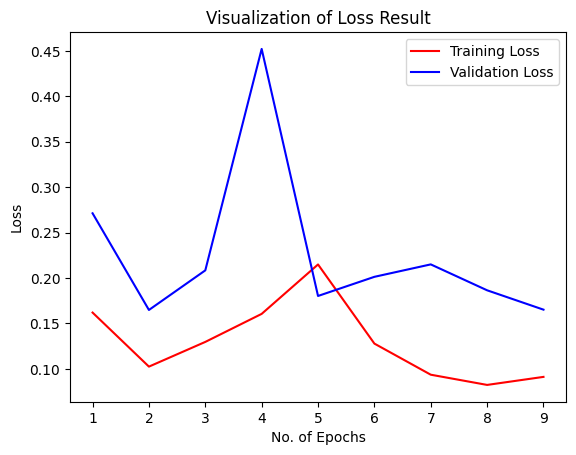

In [222]:
num_epochs = len(training_history_data['loss'])
epochs = [i for i in range(1, num_epochs + 1)] # Adjust epochs to match the training data
plt.plot(epochs, training_history_data['loss'], label="Training Loss", color='red')
plt.plot(epochs, training_history_data['val_loss'], label="Validation Loss", color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()#box which tells which line represents which aspect
plt.show()

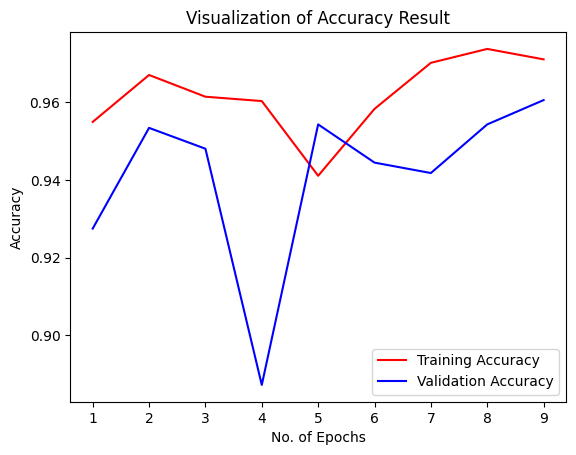

In [223]:
#Visualization of Accuracy
# Get the actual number of epochs from the training history data
num_epochs = len(training_history_data['accuracy'])
epochs = [i for i in range(1, num_epochs + 1)]  # Adjust epochs to match the training data
plt.plot(epochs, training_history_data['accuracy'], label="Training Accuracy", color='red')
plt.plot(epochs, training_history_data['val_accuracy'], label="Validation Accuracy", color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

## Precision,Recall,Confusion Matrix - Model Evaluation-II

In [224]:
y_pred = model.predict(X_test)
print(y_pred)
print(y_pred.shape)
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [3.9054477e-13 6.9599104e-11 1.1529421e-11 1.0000000e+00]
 [9.9999905e-01 9.6734834e-07 5.0728563e-08 5.4303051e-10]
 ...
 [1.5221335e-08 9.9999869e-01 1.0924742e-06 1.9147801e-07]
 [9.9995756e-01 4.1684947e-05 7.2540467e-07 3.4047947e-08]
 [6.0401449e-12 8.8878842e-08 1.2503311e-04 9.9987483e-01]]
(1117, 4)


array([2, 3, 0, ..., 1, 0, 3])

In [225]:
print(Y_test.shape)
print(Y_test)
true_categories = np.argmax(Y_test,axis=1)
true_categories

(1117, 4)
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


array([2, 3, 0, ..., 1, 0, 3])

In [226]:
classes

['classical', 'jazz', 'pop', 'rock']

In [227]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

   classical       0.95      0.98      0.97       298
        jazz       0.97      0.95      0.96       274
         pop       1.00      0.94      0.97       255
        rock       0.93      0.97      0.95       290

    accuracy                           0.96      1117
   macro avg       0.96      0.96      0.96      1117
weighted avg       0.96      0.96      0.96      1117



## Confusion Matrix Visualization

In [228]:
cm

array([[291,   3,   0,   4],
       [ 11, 261,   1,   1],
       [  0,   1, 239,  15],
       [  3,   5,   0, 282]])

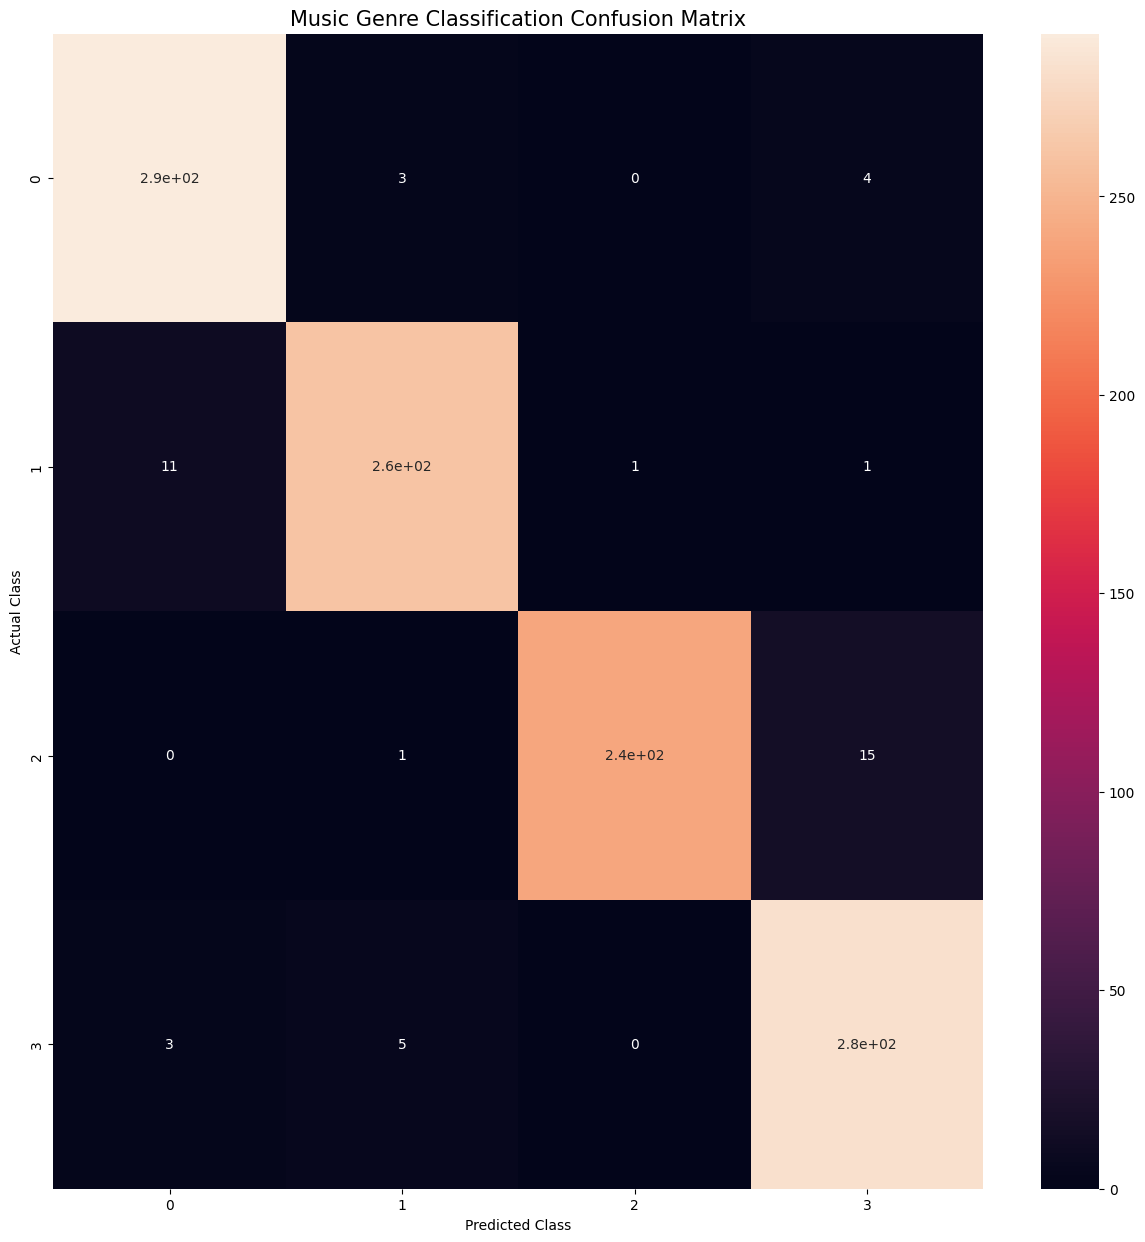

In [229]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()

In [230]:
# !pip install opencv
import seaborn as sns
from tensorflow.image import resize
import cv2

In [240]:
model = tf.keras.models.load_model("Trained_model.h5")

In [244]:
from pydub import AudioSegment
import cv2 #Imported cv2 to resize mel spectrogram

def load_and_preprocess_data(file_path, target_shape=(150, 150)):
    data = []
    # Load audio with librosa
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    # Preprocessing steps (chunk, spectrogram, resize)
    chunk_duration = 4
    overlap_duration = 2
    chunk_samples = chunk_duration * sample_rate
    overlap_samples = overlap_duration * sample_rate
    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        chunk = audio_data[start:end]
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
        # mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape) #Removed the use of tensorflow.image.resize
        target_height, target_width = target_shape
        #Using cv2.resize to resize the mel spectrogram instead of tensorflow.image.resize.
        mel_spectrogram = cv2.resize(mel_spectrogram, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
        data.append(mel_spectrogram) # Append data
    return np.array(data)


file_path = "/content/jazz.00000.wav"
temp_file_path = "temp.wav"

# Check if file exists
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
else:
    # Convert to wav if needed
    audio = AudioSegment.from_mp3(file_path)
    audio.export(temp_file_path, format="wav")

    # Load and process with updated path
    X_test = load_and_preprocess_data(temp_file_path)

In [245]:
#Model Prediction
def model_prediction(X_test,model): # Pass 'model' as an argument
    y_pred = model.predict(X_test)# It predicts the probability scores for each category in X_test using the model.
    predicted_categories = np.argmax(y_pred,axis=1)
    unique_elements, counts = np.unique(predicted_categories, return_counts=True)
    print(unique_elements, counts)
    max_count = np.max(counts)
    max_elements = unique_elements[counts == max_count]
    return max_elements[0]
model = tf.keras.models.load_model("Trained_model.h5") # Changed to 'Trained_model.keras' # Original line, kept for reference
c_index = model_prediction(X_test,model) # Pass 'model' when calling
print(f"Model Prediction :: Music Genre --> {classes[c_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
[0 1 3] [ 4 10  1]
Model Prediction :: Music Genre --> jazz


In [243]:
!pip install -U keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

# Define a custom callback to log accuracy and val_accuracy
class TrialLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: Accuracy = {logs.get('accuracy'):.4f}, Val_Accuracy = {logs.get('val_accuracy'):.4f}")

# Define the model-building function
def build_model(hp):
    model = tf.keras.Sequential()

    # Add first Conv2D layer
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=X_train[0].shape
    ))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Add second Conv2D layer
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.45, step=0.1)))

    # Output layer
    model.add(Dense(len(classes), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=9,
    factor=4,
    directory='kt_tuner',
    project_name='music_genre_tuning'
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run hyperparameter search with logging callback
tuner.search(X_train, Y_train,
             epochs=20,
             validation_split=0.2,
             callbacks=[early_stop, TrialLogger()])

# Print best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
Conv1 Filters: {best_hps.get('conv1_filters')}
Conv2 Filters: {best_hps.get('conv2_filters')}
Dense Units: {best_hps.get('dense_units')}
Dropout Rate: {best_hps.get('dropout')}
Learning Rate: {best_hps.get('learning_rate')}
""")

# Train the best model with logging
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train,
                         epochs=15,
                         validation_split=0.2,
                         callbacks=[early_stop, TrialLogger()])

# Print summary of all trials
tuner.results_summary()

Reloading Tuner from kt_tuner/music_genre_tuning/tuner0.json

Best Hyperparameters:
Conv1 Filters: 16
Conv2 Filters: 32
Dense Units: 32
Dropout Rate: 0.30000000000000004
Learning Rate: 0.001



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2943 - loss: 6.3905Epoch 1: Accuracy = 0.3452, Val_Accuracy = 0.4938
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2947 - loss: 6.3565 - val_accuracy: 0.4938 - val_loss: 1.0253
Epoch 2/15
108/112 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4836 - loss: 1.0946Epoch 2: Accuracy = 0.4866, Val_Accuracy = 0.5823
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4837 - loss: 1.0936 - val_accuracy: 0.5823 - val_loss: 0.9483
Epoch 3/15
107/112 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5397 - loss: 0.9981Epoch 3: Accuracy = 0.5465, Val_Accuracy = 0.6148
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5401 - loss: 0.9976 - val_accuracy: 0.6148 - val_loss: 0.9251
Epoch 4/15
107/112 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5525 - loss: 1.0019Epoch 4: Accuracy = 0.5658, Val_Accuracy = 0.6484
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5532 - loss: 1.0013 - val_accuracy: 0.6484 - v